In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Stimulus-driven predictive model of brain activity.
What we will need:
- "imagenet_trained_model_weights.pkl"
- The betas and experiment stimuli
- A brain mask

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fpX = np.float32
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict

import torch as T
import torch.nn as L
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

In [4]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 3
device#: 0
device name: TITAN RTX

torch: 1.3.0
cuda:  10.1.243
cudnn: 7603
dtype: torch.float32


In [5]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [ ]:
trn_subjects = [1, 2, 5, 6]

In [7]:
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) # 'Aug-10-2020_1638' #

model_name = 'alexnet_fwrf'
model_dir = '%s_%s' % (model_name, timestamp)

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/"
output_dir = root_dir+"output/multisubject/%s_%s/" % (model_name,timestamp) 
video_dir = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)   
print ("Time Stamp: %s" % timestamp)

Time Stamp: Jan-28-2021_0958


# Load the stimuli images

In [8]:
nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

In [9]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
for s in trn_subjects: 
    image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%s, 'r')
    image_data[s] = np.copy(image_data_set['stimuli'])
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', image_data[s].shape, ', dtype:', image_data[s].dtype, ', value range:',\
           np.min(image_data[s][0]), np.max(image_data[s][0]))

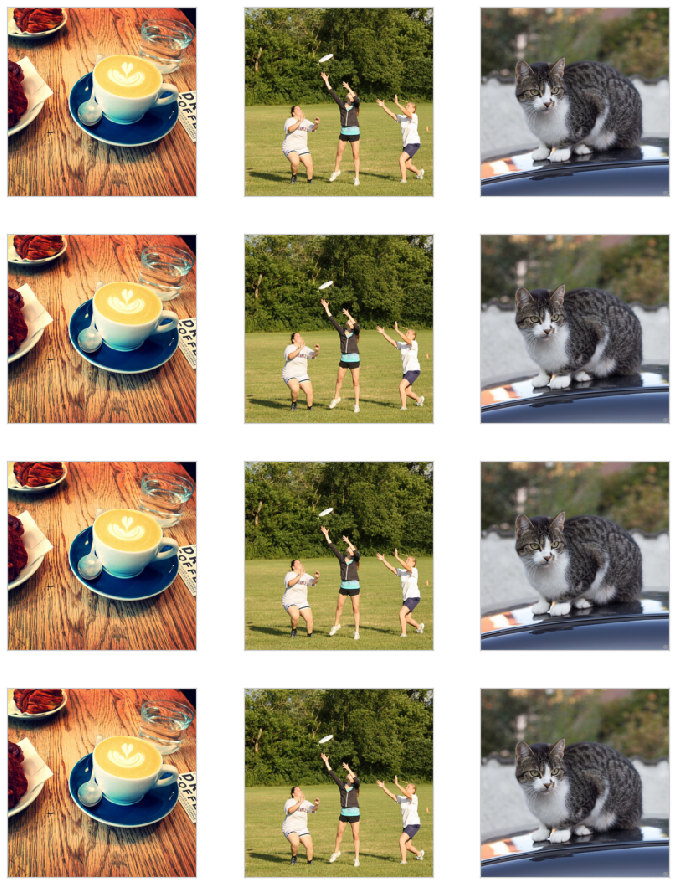

In [12]:
n = 1003
plt.figure(figsize=(12,4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(image_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

# Load the voxel data
- We load a subset (a range of voxels) of all voxel for the sake of the example.

In [13]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [14]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

brain_nii_shape, voxel_mask, voxel_idx, voxel_roi, voxel_ncsnr = {}, {}, {}, {}, {}

for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    #voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)
    voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)
    voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    #ncsnr_full = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%s)
    ###
    brain_nii_shape[s] = voxel_roi_full.shape
    print (brain_nii_shape[s])
    ###
    voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
    voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
    ###
    voxel_mask[s]  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
    voxel_idx[s]   = np.arange(len(voxel_mask[s]))[voxel_mask[s]]
    voxel_roi[s]   = voxel_joined_roi_full[voxel_mask[s]]
    #voxel_ncsnr[s] = ncsnr_full.flatten()[voxel_mask[s]]
        
    print ('full mask length = %d'%len(voxel_mask[s]))
    print ('selection length = %d'%np.sum(voxel_mask[s]))
    
    for roi_mask, roi_name in iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names):
        print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

--------  subject 1  -------
(81, 104, 83)
full mask length = 699192
selection length = 4627
594 	: V1v
754 	: V1d
827 	: V2v
588 	: V2d
651 	: V3v
537 	: V3d
676 	: V4
--------  subject 2  -------
(82, 106, 84)
full mask length = 730128
selection length = 3765
532 	: V1v
565 	: V1d
621 	: V2v
462 	: V2d
549 	: V3v
532 	: V3d
504 	: V4
--------  subject 5  -------
(79, 97, 78)
full mask length = 597714
selection length = 3685
462 	: V1v
653 	: V1d
520 	: V2v
568 	: V2d
473 	: V3v
461 	: V3d
548 	: V4
--------  subject 6  -------
(85, 113, 83)
full mask length = 797215
selection length = 4024
405 	: V1v
725 	: V1d
584 	: V2v
607 	: V2d
551 	: V3v
664 	: V3d
488 	: V4


## Display a slice of the data

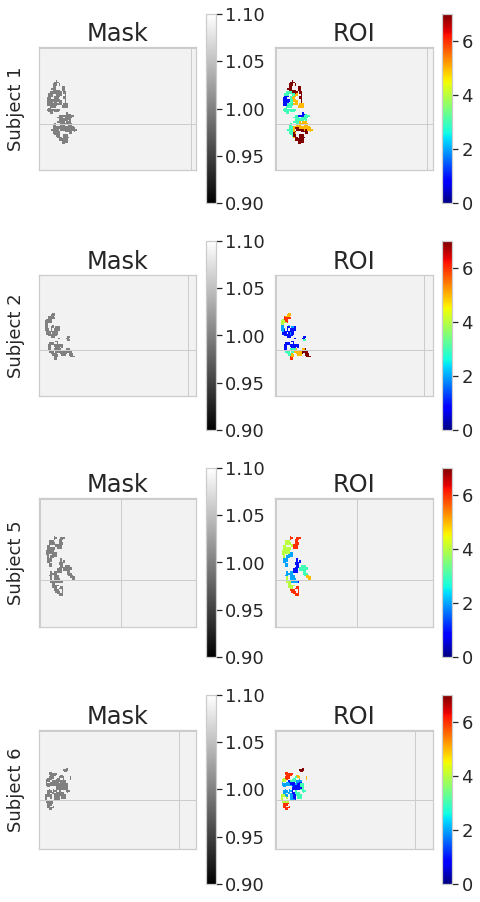

In [15]:
slice_idx = 35
plt.figure(figsize=(12, 4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    
    volume_brain_mask = view_data(brain_nii_shape[s], voxel_idx[s], np.ones_like(voxel_idx[s]), save_to=subject_dir+"subj%02d_mask"%s)
    volume_brain_roi  = view_data(brain_nii_shape[s], voxel_idx[s], voxel_roi[s], save_to=subject_dir+"subj%02d_roi"%s)
    #ncsnr_volume = view_data(brain_nii_shape[s], voxel_idx[s], voxel_ncsnr[s], save_to=subject_dir+"subj%02d_ncsnr"%s) 
    ##
    plt.subplot(len(trn_subjects),3,3*k+1)
    plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
    plt.title('Mask')
    plt.colorbar()
    _=plt.ylabel('Subject %d'%s)
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+2)
    plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
    plt.clim([0,7])
    plt.title('ROI')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    #plt.subplot(len(trn_subjects),3,3*k+3)
    #plt.imshow(ncsnr_volume[:,:,slice_idx], cmap='hot', interpolation='None')
    #plt.title('SNR')
    #plt.colorbar()
    #_=plt.gca().set_xticklabels([])
    #_=plt.gca().set_yticklabels([])

# Load voxels
## Quick load

In [16]:
voxel_data_set = h5py.File(root_dir+'voxel_data_V1_4_part1.h5py', 'r')
#voxel_data_set = h5py.File(root_dir+'voxel_data_general.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()

In [17]:
voxel_data = voxel_data_dict['voxel_data']
print (voxel_data.keys())

dict_keys(['1', '2', '5', '6'])


## Slow load from raw data

In [13]:
## Long version
from src.load_nsd import load_betas

voxel_data = {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/"%s
    voxel_data[s],_ = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask[s], up_to=-1)
    print ('----------------------------')
    print (voxel_data[s].shape)
    
save_stuff(root_dir + 'voxel_data_general_part1', 
    flatten_dict({
   'voxel_mask': voxel_mask,
   'voxel_roi': voxel_roi,
   'voxel_idx': voxel_idx,
   'voxel_ncsnr': voxel_ncsnr,
   'voxel_data': voxel_data
            }))

--------  subject 3  -------
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.mat
int16 -32768 32767 (750, 82, 106, 81)
<beta> = 2.354, <sigma> = 1.660
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.mat
int16 -32768 32767 (750, 82, 106, 81)
<beta> = 2.354, <sigma> = 1.730
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.mat
int16 -32768 32767 (750, 82, 106, 81)
<beta> = 2.542, <sigma> = 1.728
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.mat
int16 -32768 32767 (750, 82, 106, 81)
<beta> = 2.314, <sigma> = 1.569
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.mat
int16 -32768 32767 (750, 82, 106, 81)
<beta> = 2.097, <sigma> = 1.565
/home/

int16 -32768 32767 (750, 80, 99, 85)
<beta> = 1.893, <sigma> = 1.424
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj04/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session12.mat
int16 -32768 32767 (750, 80, 99, 85)
<beta> = 1.722, <sigma> = 1.368
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj04/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session13.mat
int16 -32768 32767 (750, 80, 99, 85)
<beta> = 1.989, <sigma> = 1.497
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj04/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session14.mat
int16 -32768 32767 (750, 80, 99, 85)
<beta> = 1.706, <sigma> = 1.393
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj04/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session15.mat
int16 -32768 32767 (750, 80, 99, 85)
<beta> = 1.730, <sigma> = 1.411
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj04/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session16.mat
int16 -32768 32767 (750, 80, 99, 85)
<be

int16 -32768 32767 (750, 81, 95, 78)
<beta> = 1.675, <sigma> = 1.498
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session25.mat
int16 -32768 32767 (750, 81, 95, 78)
<beta> = 2.334, <sigma> = 1.759
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session26.mat
int16 -32768 32767 (750, 81, 95, 78)
<beta> = 1.645, <sigma> = 1.640
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session27.mat
int16 -32768 32767 (750, 81, 95, 78)
<beta> = 2.132, <sigma> = 1.678
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session28.mat
int16 -32768 32767 (750, 81, 95, 78)
<beta> = 1.759, <sigma> = 1.531
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj07/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session29.mat
int16 -32768 32767 (750, 81, 95, 78)
<be

<beta> = 1.457, <sigma> = 1.583
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj08/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session27.mat
int16 -32768 32767 (750, 78, 103, 80)
<beta> = 2.229, <sigma> = 1.683
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj08/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session28.mat
int16 -32768 32767 (750, 78, 103, 80)
<beta> = 2.132, <sigma> = 1.803
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj08/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session29.mat
int16 -32768 32767 (750, 78, 103, 80)
<beta> = 1.910, <sigma> = 1.676
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj08/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session30.mat
int16 -32768 32767 (750, 78, 103, 80)
<beta> = 1.406, <sigma> = 1.480
----------------------------
(22500, 3490)


## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.
- We could have reduced the number of voxels already but I needed them for something else at another point.

In [18]:
from src.load_nsd import  image_feature_fn, data_split

data_size, nnv = {}, {}
trn_stim_data, trn_voxel_data  = {}, {}
val_stim_single_trial_data, val_voxel_single_trial_data = {}, {}
val_stim_multi_trial_data, val_voxel_multi_trial_data = {}, {}

for k,s in enumerate(trn_subjects):
    data_size[s], nnv[s] = voxel_data['%s'%s].shape 
    print ('--------  subject %d  -------' % s)
    trn_stim_data[s], trn_voxel_data[s],\
    val_stim_single_trial_data[s], val_voxel_single_trial_data[s],\
    val_stim_multi_trial_data[s], val_voxel_multi_trial_data[s] = \
        data_split( image_feature_fn(image_data[s]), voxel_data['%s'%s], ordering, imagewise=True)

--------  subject 1  -------
Total number of voxels = 4627
Validation size = 3000 , Training size = 27000


In [ ]:
del voxel_data
del image_data

In [19]:
trn_stim_mean = sum([np.mean(trn_stim_data[s], axis=(0,2,3), keepdims=True) for s in trn_subjects])/len(trn_subjects)
print (trn_stim_mean)

[[[[0.47599807]]

  [[0.45186967]]

  [[0.4118617 ]]]]


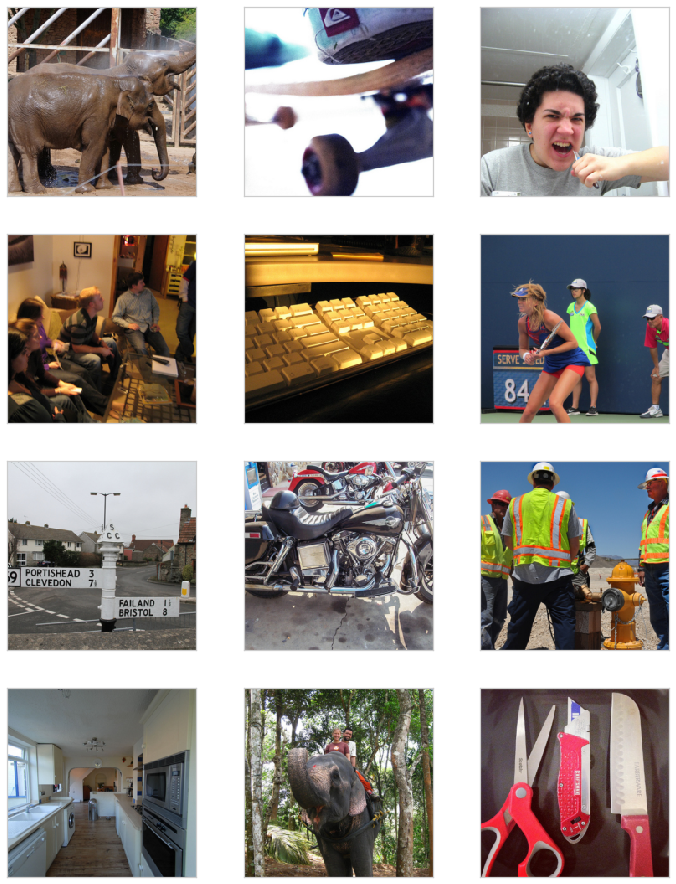

In [20]:
n = 6
plt.figure(figsize=(12,4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(trn_stim_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

---
# Load Model

In [22]:
def get_value(_x):
    return np.copy(_x.data.cpu().numpy())
def set_value(_x, x):
    _x.data.copy_(T.from_numpy(x))
def subject_pred_pass(s, x, v, batch_size):
    pred = get_predictions(x, _fmaps_fn, _fwrf_fn, best_params[s], sample_batch_size=batch_size)
    return pred
def validation_fn(s, xb):
    _,r,_ = model_fn(s, T.from_numpy(xb).to(device))
    return r
def subject_validation_pass(s, x, v, batch_size):
    val_cc  = np.zeros(shape=(v.shape[1]), dtype=v.dtype)
    val_pred = subject_pred_pass(s, x, v, batch_size)
    for i in range(v.shape[1]):
        val_cc[i] = np.corrcoef(v[:,i], val_pred[:,i])[0,1]                  
    return val_cc
def validation_(stims, voxels, batch_size):
    subject_val_cc = {}
    #shared_model.eval()
    for s in voxels.keys():          
        val_cc = subject_validation_pass(s, stims[s], voxels[s], batch_size) 
        subject_val_cc[s] = np.nan_to_num(val_cc)    
    return subject_val_cc
def sample_with_replacement(indices):
    return indices[np.random.randint(len(indices), size=len(indices))]    
def cc_resampling_with_replacement(s, x, v, batch_size, n_resample=1):
    pred = subject_pred_pass(s, x, v, batch_size)
    cc = np.zeros(shape=(v.shape[1]), dtype=fpX)
    ccs = []
    for rs in tqdm(range(n_resample)):
        res = sample_with_replacement(np.arange(len(pred)))
        data_res = v[res]
        pred_res = pred[res]
        for i in range(sub_nv[s]):
            cc[i] = np.corrcoef(data_res[:,i], pred_res[:,i])[0,1]  
        ccs += [np.nan_to_num(cc)]
    return ccs

In [23]:
from torchvision.models.alexnet import Alexnet_fmaps
from src.torch_fwrf import Torch_fwRF_voxel_block
_fmaps_fn = Alexnet_fmaps().to(device)

_x = torch.tensor(trn_stim_data[trn_subjects[0]][:100]).to(device) # the input variable.
_fmaps = _fmaps_fn(_x)
for k,_fm in enumerate(_fmaps):
    print (_fm.size())

torch.Size([100, 64, 27, 27])
torch.Size([100, 192, 27, 27])
torch.Size([100, 384, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 4096, 1, 1])
torch.Size([100, 4096, 1, 1])
torch.Size([100, 1000, 1, 1])


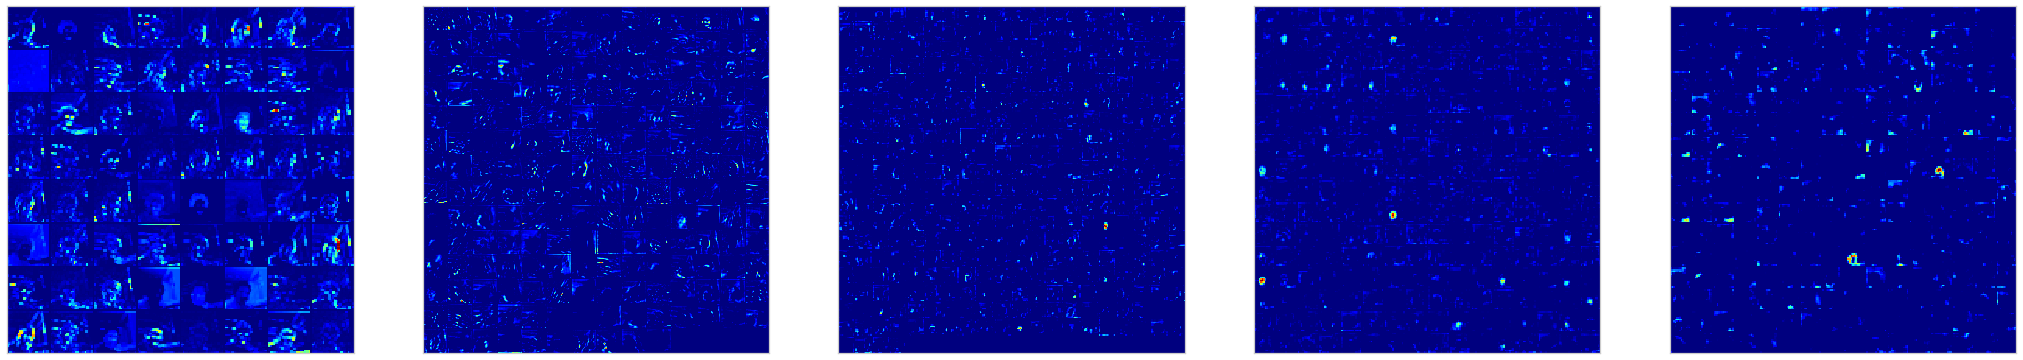

In [24]:
plt.figure(figsize=(36,12))
for k,_fm in enumerate(_fmaps[:5]):
    plt.subplot(1,5,k+1)
    plt.imshow(pnu.mosaic_vis(get_value(_fm)[8], pad=1), interpolation='None', cmap='jet')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  

In [25]:
from src.torch_feature_space import filter_dnn_feature_maps

# I used image_data because the repeats are not relevant
_fmaps_fn, lmask, fmask, tuning_masks = filter_dnn_feature_maps(trn_stim_data[trn_subjects[0]], _fmaps_fn, batch_size=100, fmap_max=512)

90it [00:07, 12.57it/s]

layer: 0, shape=(100, 64, 27, 27)
layer: 1, shape=(100, 192, 27, 27)
layer: 2, shape=(100, 384, 13, 13)
layer: 3, shape=(100, 256, 13, 13)
layer: 4, shape=(100, 256, 13, 13)
layer: 5, shape=(100, 512, 1, 1)
layer: 6, shape=(100, 512, 1, 1)
layer: 7, shape=(100, 512, 1, 1)

fmaps: 0, shape=(100, 256, 27, 27)
fmaps: 1, shape=(100, 896, 13, 13)
fmaps: 2, shape=(100, 1536, 1, 1)


In [26]:
_x = torch.tensor(trn_stim_data[trn_subjects[0]][:100]).to(device) # the input variable.
_fmaps = _fmaps_fn(_x)
for k,_fm in enumerate(_fmaps):
    print (_fm.size())

torch.Size([100, 256, 27, 27])
torch.Size([100, 896, 13, 13])
torch.Size([100, 1536, 1, 1])


In [27]:
from PIL import Image
from matplotlib.patches import Patch
im_frame = Image.open(root_dir + 'J4_r_alpha_2D.png')
cmap = np.array(im_frame.getdata()).reshape((256,256,4))[:10]

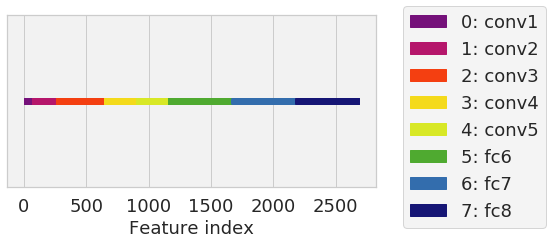

In [28]:
layer_names = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']
fig=plt.figure(figsize=(8, 4))
plt.subplots_adjust(left=0.01, bottom=0.35, right=.65, top=.95, wspace=0.16, hspace=0.)
legend_elements = [Patch(facecolor=tuple(cmap[0,int(float(k)*255./(len(tuning_masks)-1))]/255), edgecolor=tuple(cmap[0,int(float(k)*255./(len(tuning_masks)-1))]/255), label='%d: %s'%(k, layer_names[k])) for k,tm in enumerate(tuning_masks)]
for k,tm in enumerate(tuning_masks):
    _=plt.plot(tm, marker='|', linestyle='None', color=tuple(cmap[0,int(float(k)*255./(len(tuning_masks)-1))]/255))
#_=plt.title('Feature index layer correspondence')
_=plt.xlabel('Feature index')
_=plt.ylim([.95, 1.05])
_=plt.yticks([])
_=plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1.1))

In [35]:
from src.rf_grid    import linspace, logspace, model_space, model_space_pyramid
from src.torch_fwrf import learn_params_ridge_regression, get_predictions

aperture = np.float32(1)
nx = ny = 11
smin, smax = np.float32(0.03), np.float32(0.4)
ns = 8

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
#model_specs = [[(0., aperture*1.1), (0., aperture*1.1), (smin, smax)], [linspace(nx), linspace(ny), logspace(ns)]]
#models = model_space(model_specs)
models = model_space_pyramid(logspace(ns)(smin, smax), min_spacing=1.4, aperture=1.1*aperture)
print ('candidate count = ', len(models))


_log_act_func = lambda _x: torch.log(1 + torch.abs(_x))*torch.tanh(torch.abs(_x))

candidate count =  1414


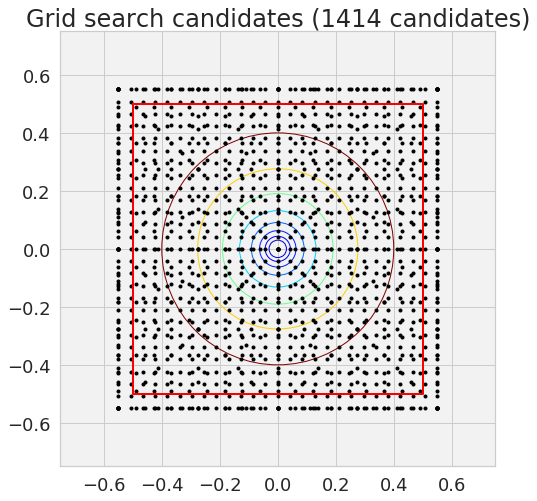

In [36]:
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
import matplotlib.cm as cmx

lx, vx = aperture, aperture * 1.5
cNorm  = colors.Normalize(vmin=.0, vmax=.4)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('jet') )

plt.figure(figsize=(8, 8))
plt.title('Grid search candidates (%d candidates)' % len(models))
plt.plot(models[:,0], models[:,1], '.k', linestyle='None')
ax = plt.gca()
for s in np.unique(models[:,2]):
    ax.add_artist(Ellipse(xy=(0,0), width=2*s, height=2*s, angle=0,
        color=scalarMap.to_rgba(s), lw=1, fill=False))
_=ax.set_xlim(-vx/2, vx/2)
_=ax.set_ylim(-vx/2, vx/2)
_=ax.set_aspect('equal')
plt.plot([-lx/2,lx/2,lx/2,-lx/2,-lx/2], [lx/2,lx/2,-lx/2,-lx/2, lx/2], 'r', lw=2)

In [37]:
def learn_params_(_fmaps_fn, stims, voxels, sample_batch_size, voxel_batch_size, holdout_size, lambdas, aperture, trn_size=None, randomize=False):
    from src.torch_fwrf import  learn_params_ridge_regression, get_predictions, Torch_fwRF_voxel_block
    best_losses, best_lambdas, best_params = {}, {}, {}
    for k,s in enumerate(voxels.keys()):
        if trn_size is None:
            ts = len(stims[s])
        else:
            ts = min(trn_size, len(stims[s]))
        index = np.arange(len(stims[s]))
        if randomize:
            np.random.shuffle(index)
        ###
        best_losses[s], best_lambdas[s], best_params[s] = learn_params_ridge_regression(
            stims[s][index[:ts]], voxels[s][index[:ts]], _fmaps_fn, models, lambdas, \
            aperture=aperture, _nonlinearity=None, zscore=True, sample_batch_size=sample_batch_size, \
            voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, shuffle=False, add_bias=True)
    ###
    return best_params, best_losses, best_lambdas, index[:ts], index[ts:]

## Training

In [40]:
voxel_batch_size = 500
holdout_size = 1000
lambdas = np.logspace(3.,6.,9, dtype=np.float32)

best_params, best_losses, best_lambdas = \
    learn_params_(_fmaps_fn, trn_stim_data, trn_voxel_data, sample_batch_size, voxel_batch_size, holdout_size, lambdas, aperture, trn_size=None, randomize=False)

trn_size = 8000 (88.9%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model 1413 of 1414, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 5630.137608s
total throughput = 1.216801s/voxel
voxel throughput = 0.219720s/voxel
setup throughput = 3.262725s/model
trn_size = 8000 (88.9%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model 1413 of 1414, voxels [  3500:3764  ] of 3765
---------------------------------------
total time = 5451.090550s
total throughput = 1.447833s/voxel
voxel throughput = 0.222348s/voxel
setup throughput = 3.263047s/model
trn_size = 8000 (88.9%)
dtype = <class 'numpy.float32'>
device = c

In [41]:
print ([p.shape if p is not None else None for p in best_params[1]])

[(4627, 3), (4627, 2688), (4627,), (4627, 2688), (4627, 2688)]


Text(0, 0.5, 'Count')

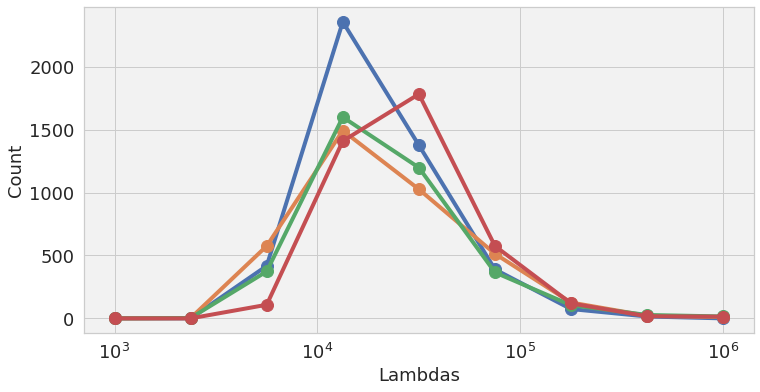

In [42]:
fig=plt.figure(figsize=(12,6))
for s,bl in best_lambdas.items():
    plt.plot(lambdas, [np.sum(bl==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')
plt.xlabel('Lambdas')
plt.ylabel('Count')

# Holdout validation

In [ ]:
from src.torch_fwrf import Torch_fwRF_voxel_block
sample_batch_size = 200

param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params[list(best_params.keys())[0]]]
_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, _nonlinearity=None, input_shape=val_stim_data[list(val_stim_data.keys())[0]].shape, aperture=1.0)

subject_hld_cc = validation_({s: v[-holdout_size:] for s,v in trn_stim_data.items()}, {s: v[-holdout_size:] for s,v in trn_voxel_data.items()}, sample_batch_size)
joined_hld_cc = np.concatenate(list(subject_val_cc.values()), axis=0)

samples [  800:999  ] of 1000, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 35.475780s
sample throughput = 0.035476s/sample
voxel throughput = 0.007667s/voxel
samples [  800:999  ] of 1000, voxels [  3500:3764  ] of 3765
---------------------------------------
total time = 27.849779s
sample throughput = 0.027850s/sample
voxel throughput = 0.007397s/voxel
samples [  800:999  ] of 1000, voxels [  3500:3684  ] of 3685
---------------------------------------
total time = 14.550950s
sample throughput = 0.014551s/sample
voxel throughput = 0.003949s/voxel
samples [  800:999  ] of 1000, voxels [  1500:1999  ] of 4024

In [ ]:
#print ("best joint score = %.3f"%best_joint_cc_score)
print ("best joint val cc = %.3f"% np.median(joined_hld_cc))
for s,v in subject_hld_cc.items():
    print ("subject %s: val cc = %.3f"%(s, np.median(v)))

fig=plt.figure(figsize=(12,4))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(joined_hld_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.1, 0.9])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

## Validation

In [43]:
from src.torch_fwrf import Torch_fwRF_voxel_block
sample_batch_size = 200

param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params[list(best_params.keys())[0]]]
_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, _nonlinearity=None, input_shape=val_stim_data[list(val_stim_data.keys())[0]].shape, aperture=1.0)

subject_val_cc = validation_(val_stim_single_trial_data, val_voxel_single_trial_data, sample_batch_size)
joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)

samples [ 2800:2999 ] of 3000, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 50.796467s
sample throughput = 0.016932s/sample
voxel throughput = 0.010978s/voxel
samples [ 2800:2999 ] of 3000, voxels [  3500:3764  ] of 3765
---------------------------------------
total time = 40.048574s
sample throughput = 0.013350s/sample
voxel throughput = 0.010637s/voxel
samples [ 2800:2999 ] of 3000, voxels [  3500:3684  ] of 3685
---------------------------------------
total time = 26.812598s
sample throughput = 0.008938s/sample
voxel throughput = 0.007276s/voxel
samples [ 2200:2370 ] of 2371, voxels [  4000:4023  ] of 4024
---------------------------------------
total time = 32.359357s
sample throughput = 0.013648s/sample
voxel throughput = 0.008042s/voxel


best joint val cc = 0.303
subject 1: val cc = 0.352
subject 2: val cc = 0.335
subject 5: val cc = 0.285
subject 6: val cc = 0.259


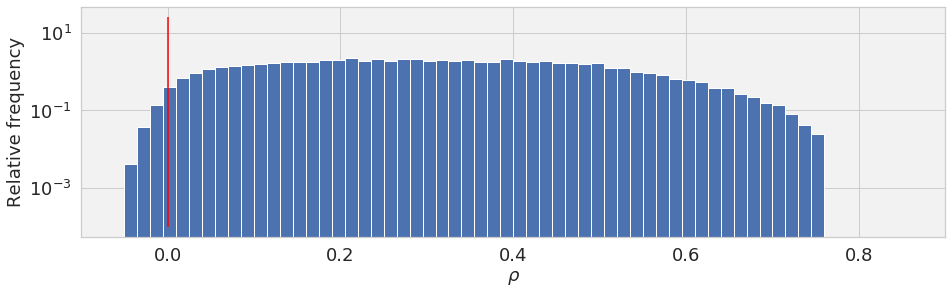

In [44]:
#print ("best joint score = %.3f"%best_joint_cc_score)
print ("best joint val cc = %.3f"% np.median(joined_val_cc))
for s,v in subject_val_cc.items():
    print ("subject %s: val cc = %.3f"%(s, np.median(v)))

fig=plt.figure(figsize=(12,4))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(joined_val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.1, 0.9])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

# Save results to file

In [48]:
#subj = trn_subjects[0] # for s in val_subjects
subject_dir = output_dir #+ 'S%02d/'%subj

torch.save({
            'sample_batch_size': sample_batch_size,
            'voxel_batch_size': voxel_batch_size,
            'holdout_size': holdout_size,   
            'best_params': best_params, 
            'val_cc': subject_val_cc,
            'voxel_index': voxel_idx,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask
            }, subject_dir+'model_params')

# Uncertainty

In [69]:
n_resample = 64
subject_resample_val_cc = {}
mccs = {}

for s in val_voxel_data.keys():
    print ('sampling subject %d'%s)
    subject_resample_val_cc[s] = cc_resampling_with_replacement(s, val_stim_data[s], val_voxel_data[s], sample_batch_size, n_resample)
    mccs[s] = [np.median(cc) for cc in subject_resample_val_cc[s]]

sampling subject 1
samples [ 2800:2999 ] of 3000, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 30.982212s
sample throughput = 0.010327s/sample
voxel throughput = 0.006696s/voxel


100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


score mean = 0.3483, std.dev = 0.0033
Subject 1 median cc mean = 0.3483, std.dev = 0.0033


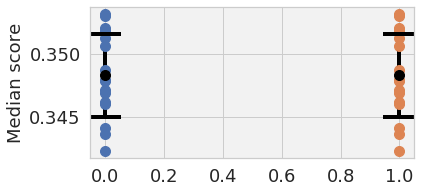

In [70]:
fig=plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.2, bottom=0.60, right=.95, top=.95, wspace=0., hspace=0.)
val_score_samples = [np.median(np.concatenate([ccs[i] for s,ccs in subject_resample_val_cc.items()], axis=0))\
    for i in range(n_resample)]
print ('score mean = %.04f, std.dev = %.04f'% (np.mean(val_score_samples),  np.std(val_score_samples)))
plt.plot([0,]*len(val_score_samples), val_score_samples, linestyle='None', marker='o', ms=10)
plt.errorbar(x=[0,], y=[np.mean(val_score_samples),], yerr=[np.std(val_score_samples),], marker='o',\
    color='k', ms=10, elinewidth=4,capsize=16, capthick=4)

for k,(s,ccs) in enumerate(subject_resample_val_cc.items()): 
    mcc = [np.median(cc) for cc in ccs]
    print ('Subject %s median cc mean = %.04f, std.dev = %.04f'% (s, np.mean(mcc), np.std(mcc)))
    plt.plot([k+1,]*len(mcc), mcc, linestyle='None', marker='o', ms=10)
    plt.errorbar(x=[k+1,], y=[np.mean(mcc),], yerr=[np.std(mcc),], marker='o',\
             color='k', ms=10, elinewidth=4,capsize=16, capthick=4)
    plt.ylabel('Median score')

# SCALING

In [32]:
trn_sizes = np.array([1,2,3,6,9,18,27]) * 1000 # [1,2,3,6,9,18,27]
#trn_trial = np.array([18,9,6,3,2,1,1])
holdout_perc = .2
ho_sizes = np.floor(holdout_perc * trn_sizes).astype(int)
print (trn_sizes)
print (ho_sizes)

[ 1000  2000  3000  6000  9000 18000 27000]
[ 200  400  600 1200 1800 3600 5400]


In [39]:
sample_batch_size = 200
voxel_batch_size = 500
n_resample = 64
n_trial    = 4

lambdas = np.logspace(3.,6.,9, dtype=np.float32)

characteristics = {'subjects': list(val_voxel_data.keys()),
                   'trn_sizes': trn_sizes,
                   'n_resample': n_resample,
                   'n_trial': n_trial
                  }
for s in val_voxel_data.keys():
    characteristics[s] = {'val_cc': len(val_stim_data)}

###
for k,(ts,hs) in enumerate(zip(trn_sizes[::-1], ho_sizes[::-1])):
    for t in range(n_trial):
        
        # training            
        best_params, best_losses, best_lambdas = \
            learn_params_(_fmaps_fn, trn_stim_data, trn_voxel_data, sample_batch_size, voxel_batch_size, hs, lambdas, aperture, trn_size=ts, randomize=True)

        # validation   
        param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params[list(best_params.keys())[0]]]
        _fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, _nonlinearity=None, input_shape=val_stim_data[list(val_stim_data.keys())[0]].shape, aperture=1.0)

        subject_val_cc = validation_(val_stim_single_trial_data, val_voxel_single_trial_data, sample_batch_size)
        joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)

        # uncertainty
        mccs = {}
        for s in val_voxel_data.keys():
            subject_resample_val_cc = cc_resampling_with_replacement(s, val_stim_single_trial_data[s], val_voxel_single_trial_data[s], sample_batch_size, n_resample)
            mccs[s] = [np.median(cc) for cc in subject_resample_val_cc]      

        # save
        for s in val_voxel_data.keys():
            characteristics[s]['run%d_trial%d'%(k,t)] = {'trn_size': min(ts, len(trn_stim_data[s])),
                              'hld_size': hs,
                              'best_lambdas': best_lambdas[s],
                              'median_val_samples': np.array(mccs[s]),
                              'val_cc': subject_val_cc[s]}
        # print a summary
        print ('================================================')
        print ('median cc = %.3f, max cc = %.3f' % (np.median(joined_val_cc), np.max(joined_val_cc)))
        print ('================================================')

trn_size = 3600 (40.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model    2 of 1414, voxels [  4500:4626  ] of 4627

KeyboardInterrupt: 

Text(0, 0.5, 'Count')

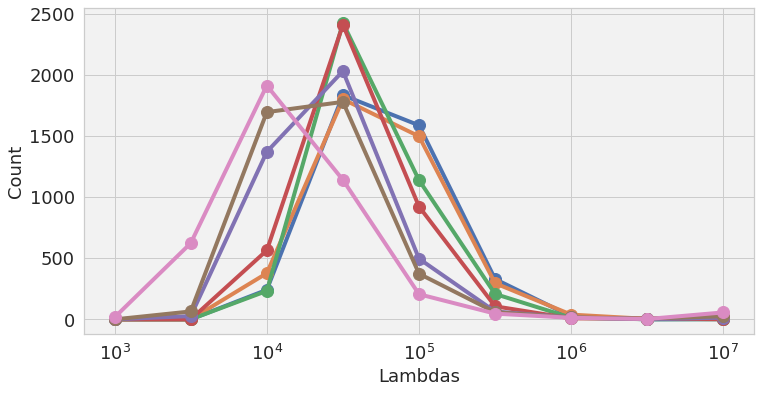

In [34]:
fig=plt.figure(figsize=(12,6))
for i,ts in enumerate(trn_sizes):
    plt.plot(lambdas, [np.sum(characteristics[trn_subjects[0]]['run%d_trial0'%i]['best_lambdas']==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')
plt.xlabel('Lambdas')
plt.ylabel('Count')

In [35]:
scaling_filepath = output_dir + "validation_accuracy_scaling"
print (scaling_filepath)

save_stuff(scaling_filepath, flatten_dict(characteristics))

/home/styvesg/Documents/PostDoc/GitRepo/nsd/output/multisubject/dnn_fwrf_Dec-26-2020_0941/validation_accuracy_scaling
saved subjects@0 in h5py file
saved trn_sizes in h5py file
saved n_resample in h5py file
saved n_trial in h5py file
saved 6.val_cc in h5py file
saved 6.run0_trial0.trn_size in h5py file
saved 6.run0_trial0.hld_size in h5py file
saved 6.run0_trial0.best_lambdas in h5py file
saved 6.run0_trial0.median_val_samples in h5py file
saved 6.run0_trial0.val_cc in h5py file
saved 6.run1_trial0.trn_size in h5py file
saved 6.run1_trial0.hld_size in h5py file
saved 6.run1_trial0.best_lambdas in h5py file
saved 6.run1_trial0.median_val_samples in h5py file
saved 6.run1_trial0.val_cc in h5py file
saved 6.run2_trial0.trn_size in h5py file
saved 6.run2_trial0.hld_size in h5py file
saved 6.run2_trial0.best_lambdas in h5py file
saved 6.run2_trial0.median_val_samples in h5py file
saved 6.run2_trial0.val_cc in h5py file
saved 6.run3_trial0.trn_size in h5py file
saved 6.run3_trial0.hld_size i

In [36]:
subj = trn_subjects[0]

actual_trn_size, result_cc, mean_median_cc, std_median_cc = [],[],[],[]
for k,ts in enumerate(trn_sizes): #characteristics['trn_size']
    cc_samples, cc_median_samples = [], []
    for t in range(characteristics['n_trial']):
        cc_samples += list(characteristics[subj]['run%d_trial%d'%(k,t)]['val_cc'])
        cc_median_samples += list(characteristics[subj]['run%d_trial%d'%(k,t)]['median_val_samples'])
    actual_trn_size += [characteristics[subj]['run%d_trial%d'%(k,0)]['trn_size'],]
    result_cc += [np.copy(np.array(cc_samples)),]
    mean_median_cc += [np.mean(np.array(cc_median_samples))]
    std_median_cc += [np.std(np.array(cc_median_samples))] 

Text(0, 0.5, 'Median validation accuracy')

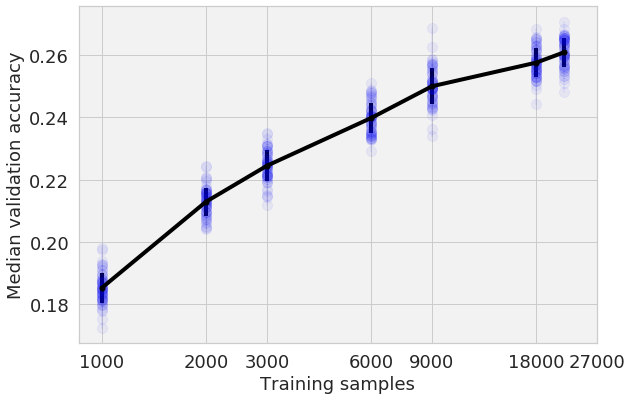

In [38]:
fig=plt.figure(figsize=(18,6))
plt.subplots_adjust(left=0.2, bottom=0.2, right=1., top=.98, wspace=0., hspace=0.)
plt.subplot(1,2,1)
for k,ts in enumerate(trn_sizes): #characteristics['trn_size']
    for t in range(characteristics['n_trial']):
        plt.plot([characteristics[subj]['run%d_trial%d'%(k,t)]['trn_size'],]*len(characteristics[subj]['run%d_trial%d'%(k,t)]['median_val_samples']), 
                 characteristics[subj]['run%d_trial%d'%(k,t)]['median_val_samples'],
                 color='b', marker='o', ms=10, alpha=.05)
plt.errorbar(actual_trn_size, mean_median_cc, std_median_cc, marker='.', ms=10, color='k', lw=4)
plt.xscale('log')
plt.gca().set_xticks(trn_sizes)
plt.gca().set_xticklabels(trn_sizes)
plt.xlabel('Training samples')
plt.ylabel('Median validation accuracy')

In [39]:
filename = output_dir + "median_validation_accuracy_%s%s" % (timestamp, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close() 

Text(0, 0.5, 'Validation accuracies')

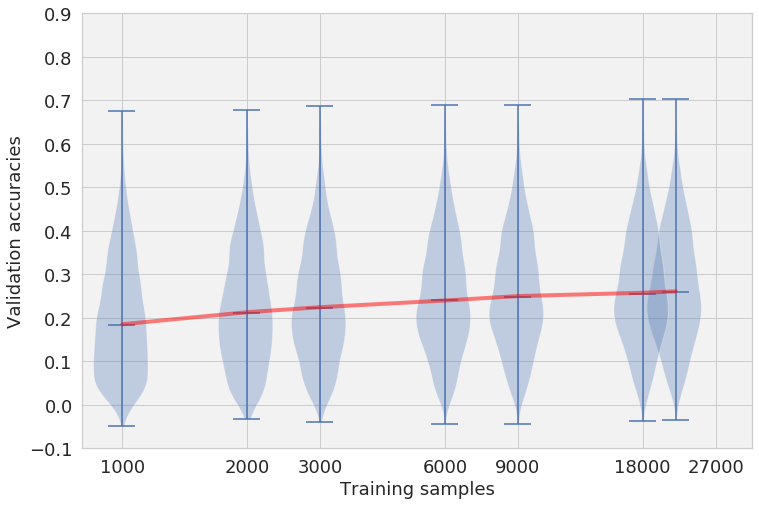

In [40]:
fig=plt.figure(figsize=(12,8))
#plt.hlines(y=[0], xmin=800, xmax=33000, color='r', lw=4, alpha=.5)
plt.plot(actual_trn_size, mean_median_cc, color='r', lw=4, alpha=.5)
#plt.fill_between([min(trn_size,s) for s in trn_sizes], np.array(cc_mns)-np.array(cc_ths), np.array(cc_mns)+np.array(cc_ths), color='r', alpha=0.3)
plt.violinplot(result_cc, positions=actual_trn_size, widths=np.array(actual_trn_size)*.3, showmedians=True)
#plt.plot([min(trn_size,s) for s in trn_sizes], median_cc, marker='o', ms=10, color='k', lw=4, alpha=.7)
plt.xscale('log')
plt.xlim([800, 33000])
plt.ylim([-.1, .9])
plt.gca().set_yticks(np.linspace(-.1,.9, 11))
plt.gca().set_xticks(trn_sizes)
plt.gca().set_xticklabels(trn_sizes)
plt.xlabel('Training samples')
plt.ylabel('Validation accuracies')

In [41]:
filename = output_dir + "validation_distributions_%s%s" % (timestamp, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close() 